# Use `ocetrac-unstruct` to identify and track marine heatwaves
This example using 40 years of Daily outputs at 5km native grid resolution takes ~45 minutes on 512 cores.

In [1]:
import xarray as xr
import numpy as np
import dask
import ocetrac_unstruct

from tempfile import TemporaryDirectory
from getpass import getuser
from pathlib import Path
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, LocalCluster
import subprocess
import re

import warnings
warnings.filterwarnings('ignore')

In [2]:
scratch_dir = Path('/scratch') / getuser()[0] / getuser() / 'mhws' 

## Start Dask Cluster

In [3]:
cluster_scratch = Path('/scratch') / getuser()[0] / getuser() / 'clients'
dask_tmp_dir = TemporaryDirectory(dir=cluster_scratch)
dask.config.set(temporary_directory=dask_tmp_dir.name)

In [4]:
## GPU Cluster (Local)
cluster = LocalCluster(n_workers=16, threads_per_worker=4)
client = Client(cluster)
#client

remote_node = subprocess.run(['hostname'], capture_output=True, text=True).stdout.strip().split('.')[0]
port = re.search(r':(\d+)/', client.dashboard_link).group(1)
print(f"Forward with Port = {remote_node}:{port}")

client.dashboard_link

Forward with Port = l40243:8787


'http://127.0.0.1:8787/status'

In [5]:
# scale = 512

# ## Distributed Cluster (without GPU)
# clusterDistributed = SLURMCluster(name='dask-cluster',
#                                     cores=16,
#                                     memory='500GB',
#                                     processes=64,  # 4 threads
#                                     interface='ib0',
#                                     queue='compute',
#                                     account='bk1377',
#                                     walltime='00:59:00',
#                                     asynchronous=0,
#                                     job_extra_directives = [f'--constraint=512G --mem=0'],
#                                     log_directory=f'/home/b/{getuser()}/.log_trash',
#                                     local_directory=dask_tmp_dir.name,
#                                     scheduler_options={'dashboard_address': ':8889'})

# clusterDistributed.scale(scale)
# clientDistributed = Client(clusterDistributed)
# remote_node = subprocess.run(['hostname'], capture_output=True, text=True).stdout.strip().split('.')[0]
# port = re.search(r':(\d+)/', clientDistributed.dashboard_link).group(1)
# print(f"Forward Port = {remote_node}:{port}")
# print(f"localhost:{port}/status")

## Load Pre-processed Data
(cf. `01_preprocess_unstruct.ipynb`)

In [6]:
chunk_size = {'time': 4}
time_subset = slice(365*2,-1)  # Skip the first 2 years
ds = xr.open_zarr(str(scratch_dir / '01_preprocess_unstruct.zarr'), chunks={'time': 2, 'ncells': -1}).drop_vars({'decimal_year', 'dayofyear'}).isel(time=time_subset).chunk(chunk_size)

In [7]:
binary_out = ds.features_notrend.drop_vars({'lat','lon'})
binary_out

<xarray.DataArray 'features_notrend' (time: 13148, ncells: 14886338)> Size: 196GB
dask.array<rechunk-merge, shape=(13148, 14886338), dtype=bool, chunksize=(4, 14886338), chunktype=numpy.ndarray>
Coordinates:
  * ncells   (ncells) int64 119MB 0 1 2 3 ... 14886335 14886336 14886337
  * time     (time) datetime64[ns] 105kB 2004-01-01T23:59:00 ... 2039-12-30T2...

In [8]:
mask = ds.mask.drop_vars({'lat','lon'}).compute().data

## Run Tracker

In [9]:
# Tracking Parameters
threshold_percentile = 0.95
min_size_quartile = 0.90      # percent   *NB: At 5km (vs ~25km for regridded data, we find many more very small objects!)
radius = 250.0                # km
resolution = 5.0              # km

In [10]:
tracker = ocetrac_unstruct.Tracker(binary_out, scratch_dir=str(scratch_dir / 'ocetrac_unstruct_scratch'), radius=radius, resolution=resolution, min_size_quartile=min_size_quartile, timedim='time', xdim='ncells', neighbours=ds.neighbours, land_mask=mask)

#### Investigating Opening/Closing

In [11]:
binary_original = tracker.da.isel(time=slice(100,102)).persist()

In [12]:
from numba import njit, int64, int32, void, prange

In [13]:
import pyicon as pyic

----Start loading pyicon.
----Start loading pyicon.
----Pyicon was loaded successfully.
----Pyicon was loaded successfully.


In [14]:
zarr_fpath_tgrid = scratch_dir  / f'fpath_tgrid.zarr'

In [84]:
@njit(parallel=True) #fastmath=True, 
def sparse_bool_power(vec, sp_data, indices, indptr, exponent):
    vec = vec.T
    num_rows = indptr.size - 1
    num_cols = vec.shape[1]
    result = vec.copy()

    for _ in range(exponent):
        temp_result = np.zeros((num_rows, num_cols), dtype=np.int32) #bool_)

        for i in range(num_rows):
            for k in range(num_cols):
                for j in range(indptr[i], indptr[i + 1]):
                    if sp_data[j] and result[indices[j], k]:
                        temp_result[i, k] = 1 #True
                        break

        result = temp_result

    return result.T

In [85]:
exponent = 20 #int(tracker.n_connections)
land_mask = tracker.land_mask
data = tracker.dilate_sparse.data
indices = tracker.dilate_sparse.indices
indptr = tracker.dilate_sparse.indptr

def binary_open_close(bitmap_binary):
    
    bitmap_binary_opened = sparse_bool_power(bitmap_binary, data, indices, indptr, exponent)  # This sparse_bool_power assumes the xdim (multiplying the sparse matrix) is in dim=1
    
    # Set the land values to True (to avoid artificially eroding the shore)
    bitmap_binary_opened[:, land_mask] = 1
    
    ## Opening is just the negated closing of the negated image
    #bitmap_binary_closed = ~sparse_bool_power(~bitmap_binary_opened, data, indices, indptr, exponent)
    
    return bitmap_binary_opened

In [34]:
binary_original0 = binary_original.isel(time=slice(0,2)).compute().data

In [86]:
opcl_new = binary_open_close(binary_original0.astype(np.int32))

In [87]:
opcl_new_da = xr.DataArray(opcl_new, coords=binary_original.coords, dims=binary_original.dims).isel(time=0)

Deriving triangulation object, this can take a while...
Done deriving triangulation object.


(<GeoAxes: title={'right': '2004-04-10T23:59:00'}>,
  <matplotlib.colorbar.Colorbar at 0x154ab9e6c220>])

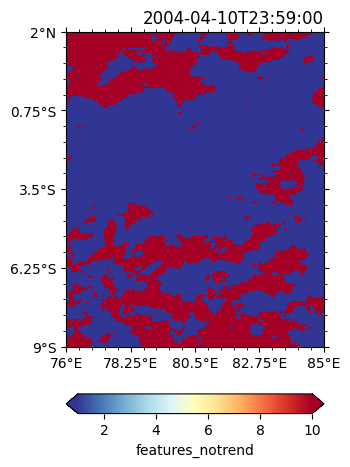

In [27]:
bin_0_da = binary_original.isel(time=0).compute()
xr.where(bin_0_da==True, 10.0, 1.0).pyic.plot(lat_reg=[-9, 2], lon_reg=[76, 85], fpath_tgrid=zarr_fpath_tgrid, plot_method='tgrid')

Deriving triangulation object, this can take a while...
Done deriving triangulation object.


(<GeoAxes: title={'right': '2004-04-10T23:59:00'}>,
  <matplotlib.colorbar.Colorbar at 0x1545fb20a560>])

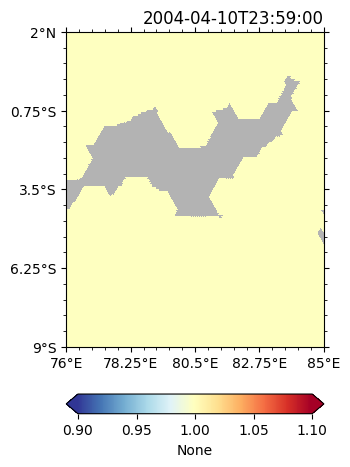

In [88]:
opcl_new_da.pyic.plot(lat_reg=[-9, 2], lon_reg=[76, 85], fpath_tgrid=zarr_fpath_tgrid, plot_method='tgrid')

Deriving triangulation object, this can take a while...
Done deriving triangulation object.


(<GeoAxes: title={'right': '2004-04-10T23:59:00'}>,
  <matplotlib.colorbar.Colorbar at 0x1545f9213eb0>])

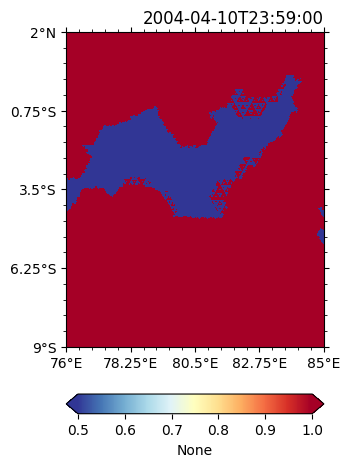

In [91]:
test = opcl_new_da.copy()
test.where(test==1, -1).pyic.plot(lat_reg=[-9, 2], lon_reg=[76, 85], fpath_tgrid=zarr_fpath_tgrid, plot_method='tgrid')

(<GeoAxes: title={'right': '2004-04-10T23:59:00'}>,
  <matplotlib.colorbar.Colorbar at 0x1545f6926fb0>])

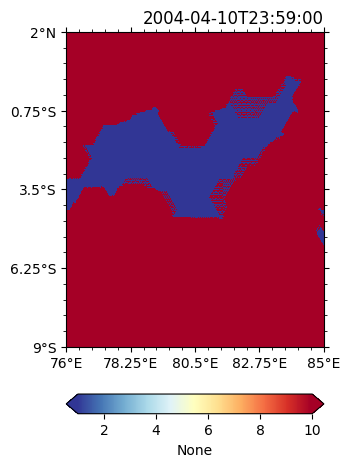

In [89]:
xr.where(opcl_new_da>0.5, 10.0, 1.0).pyic.plot(lat_reg=[-9, 2], lon_reg=[76, 85], res=0.02) #, fpath_tgrid=zarr_fpath_tgrid, plot_method='tgrid')

### Investigating Clustering

In [11]:
binary_filtered = xr.open_zarr(str(scratch_dir / 'ocetrac_unstruct_scratch' / '02_binary_images_filtered_temp.zarr'), chunks={}).binary_images_filtered

In [12]:
binary = xr.open_zarr(str(scratch_dir / 'ocetrac_unstruct_scratch' / '02_binary_images_temp.zarr'), chunks={}).binary_images

In [94]:
binary_original = tracker.da.isel(time=slice(100,102)).persist()

In [13]:
binary_images = binary.isel(time=slice(100,102)).persist()

In [ ]:
import pyicon as pyic

In [ ]:
binary_images.isel(time=0).pyic.plot()

In [16]:
binary_images_mask = binary_images.where(~tracker.land_mask, other=True).compute()

In [ ]:
binary_images_mask.isel(time=0).pyic.plot()

In [ ]:
binary_images_mask.isel(time=0).pyic.plot(lat_reg=[-14, 5], lon_reg=[70, 92], fpath_tgrid=zarr_fpath_tgrid, plot_method='tgrid')

In [ ]:
binary_original.isel(time=0).pyic.plot(lat_reg=[-14, 5], lon_reg=[70, 92], fpath_tgrid=zarr_fpath_tgrid, plot_method='tgrid')

In [20]:
from numba import njit, int64, int32, void, prange

In [63]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

In [213]:
def scipy_connected_components_clusters(arr, neighbours_int):
    n = len(arr)
    true_indices = np.where(arr)[0]
    mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(true_indices)}
    
    row_ind, col_ind = [], []
    for j in true_indices:
        for i in range(3):
            if neighbours_int[i, j] != -1 and arr[neighbours_int[i, j]]:
                row_ind.append(mapping[j])
                col_ind.append(mapping[neighbours_int[i, j]])
    
    graph = csr_matrix((np.ones(len(row_ind)), (row_ind, col_ind)), shape=(len(true_indices), len(true_indices)))
    _, labels_true = connected_components(csgraph=graph, directed=False, return_labels=True)
    
    labels = np.full(n, -1, dtype=np.int32)
    labels[true_indices] = labels_true
    
    return labels

In [206]:
# def scipy_connected_components_clusters(arr, neighbours_int):
#     n = len(arr)
#     true_indices = np.where(arr)[0]
    
#     row_ind, col_ind = [], []
#     for j in range(n):
#         if arr[j]:
#             for i in range(3):
#                 if neighbours_int[i, j] != -1 and arr[neighbours_int[i, j]] == True:
#                     row_ind.append(j)
#                     col_ind.append(neighbours_int[i, j])
    
#     graph = csr_matrix((np.ones(len(row_ind)), (row_ind, col_ind)), shape=(n, n))
#     _, labels_true = connected_components(csgraph=graph, directed=False, return_labels=True)
    
#     labels = np.full(n, -1, dtype=np.int64)
#     labels[true_indices] = labels_true[true_indices]
    
#     return labels

In [54]:
zarr_fpath_tgrid = scratch_dir  / f'fpath_tgrid.zarr'

In [161]:
import intake
cat = intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")
expid = 'eerie-control-1950'
version = 'v20231106'
model = 'icon-esm-er'
gridspec = 'native'

dat = cat['dkrz.disk.model-output'][model][expid][version]['ocean'][gridspec]

grid2d = dat['2d_grid'](chunks={}).to_dask().rename({'cell':'ncells'})

neighbours = grid2d.neighbor_cell_index.rename({'clat':'lat', 'clon':'lon'}).astype(int).chunk({'ncells':-1})

In [167]:
neighbour_temp = neighbours.compute().data - 1

In [171]:
bin_image = binary_images.isel(time=0)

In [214]:
cluster_labels = scipy_connected_components_clusters(bin_image.compute().data, neighbour_temp)

In [215]:
cl_da = xr.DataArray(cluster_labels, coords=bin_image.coords, dims=bin_image.dims)#.isel(time=0)

In [ ]:
xr.where(bin_image==True, 10.0, 1.0).pyic.plot(lat_reg=[-9, 2], lon_reg=[76, 85], fpath_tgrid=zarr_fpath_tgrid, plot_method='tgrid')

In [ ]:
(bin_image==True).pyic.plot(lat_reg=[-9, 2], lon_reg=[76, 85], fpath_tgrid=zarr_fpath_tgrid, plot_method='tgrid')

In [223]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cm = ListedColormap(np.random.random(size=(10**4, 3)).tolist())

In [ ]:
xr.where(cl_da>=0.0, cl_da, np.nan).pyic.plot(cmap=cm, lat_reg=[-9, 2], lon_reg=[76, 85], fpath_tgrid=zarr_fpath_tgrid, plot_method='tgrid')

In [ ]:
xr.where(cl_da>=0, cl_da, np.nan).pyic.plot(cmap='tab20',fpath_tgrid=zarr_fpath_tgrid)

In [ ]:
labels = xr.open_zarr(str(scratch_dir / 'ocetrac_unstruct_scratch' / '02_cluster_labels_1_temp.zarr'), chunks={}).cluster_labels

In [ ]:
labels.isel(time=100).pyic.plot()  # ^^ Should be the same...

In [13]:
blobs.attrs

In [14]:
# clientDistributed.close()

## Save Blobs
NB: Blobs file is already saved, but just move it into the `scratch_dir`

In [15]:
import shutil
shutil.move(str(scratch_dir / 'ocetrac_unstruct_scratch' / '02_final_labels.zarr'), str(scratch_dir / '02_tracked_unstruct.zarr'))